In [1]:
import sys
sys.path.append('..')

In [2]:
import json
from pathlib import Path
from collections import Counter

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import datasets

from utils.candidate_labels import CANDIDATE_LABELS

/home/workspace/notion-auto-archive/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ROOT_DIR = Path.cwd().parent

df_qiita = pd.read_json(ROOT_DIR / "data/qiita.json")
df_zenn = pd.read_json(ROOT_DIR / "data/zenn.json")

df_raw = pd.concat([df_qiita, df_zenn], axis=0)

In [16]:
hypothesis_template = "This text is about {}."

df = pd.DataFrame(
    columns=["premise", "hypothesis", "label"],
)
idx = 0
for row in df_raw.itertuples():
    
    if len(row.cleansed_content) > 1024:
        # truncate the sentence to approx. 1024 characters
        # end with a period or "#", which means next section of markdown sentences.
        try:
            if "#" in row.cleansed_content[512:1024]:
                cleansed_content = row.cleansed_content[:1024].rsplit("#", 1)[0]
            elif "。" in row.cleansed_content[512:1024]:
                cleansed_content = row.cleansed_content[:1024].rsplit("。", 1)[0] + "。"
            else:
                cleansed_content = row.cleansed_content[:1024].rsplit(".", 1)[0] + "."
        except Exception:
            cleansed_content = row.cleansed_content[:1024]
    else:
        cleansed_content = row.cleansed_content
        
    if not cleansed_content:
        continue
    
    categories = []
    for tag in row.tags:
        if tag in CANDIDATE_LABELS.keys():
            categories.append(CANDIDATE_LABELS[tag])
    
    for category in categories:
        df.at[idx, "premise"] = cleansed_content
        df.at[idx, "hypothesis"] = hypothesis_template.format(category)
        df.at[idx, "label"] = 0
        idx += 1

In [17]:
le = []
for row in df.iterrows():
    le.append(len(row[1]["premise"]))

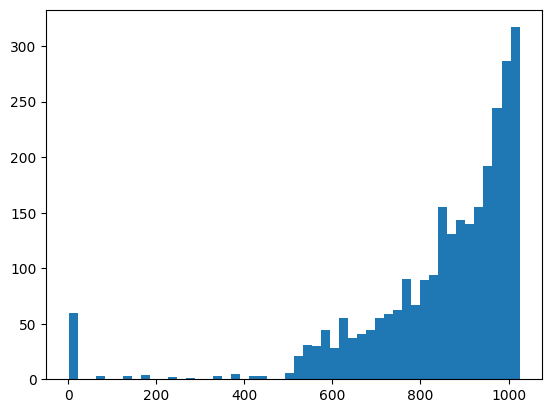

In [18]:
plt.hist(le, bins=50)
plt.show()

In [19]:
train_df, test_df = train_test_split(df, train_size=0.9)

In [20]:
datasets.Dataset.from_pandas(train_df).save_to_disk(ROOT_DIR / "data/train/jp-engineer-articles-dataset")
datasets.Dataset.from_pandas(test_df).save_to_disk(ROOT_DIR / "data/test/jp-engineer-articles-dataset")